In [13]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [14]:
# other imports
import os

import shap
shap.initjs()

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4, style='whitegrid')

from tensorflow import nn
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [15]:
def load_dataset(filename, oclusion=False, o_feature=None):
    '''
    Assumptions over the dataset:
    CSV format, last column named 'class' represents the target feature
    '''

    df = pd.read_csv(filename)

    if oclusion:
        df[o_feature] = np.random.RandomState(seed=0).permutation(df[o_feature].values)

    n_classes = len(df['class'].unique())
    df['class'] = df['class'].astype('category') # forcing categorical even if binary
    
    ohe_df = pd.get_dummies(df)

    n_features = len(ohe_df.columns) - n_classes
    
    data = ohe_df.to_numpy()
    X = data[:, :n_features]
    Y = data[:, -n_classes:]

    return df, ohe_df, X, Y

In [16]:
def fit_model(X_train, Y_train):

    n_features = X_train.shape[1]
    n_classes = Y_train.shape[1]
    
    layers = []

    layers.append(tf.keras.layers.Flatten())
    
    activ = tf.nn.relu # tf.nn.relu, tf.nn.elu, tf.nn.sigmoid

    layers.append(tf.keras.layers.Dense(2 * n_features, activation=activ)) 
    # layers.append(tf.keras.layers.Dropout(0.5))
    layers.append(tf.keras.layers.Dense(n_features, activation=activ))
    # layers.append(tf.keras.layers.Dropout(0.5))

    layers.append(tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax))

    nn_model = tf.keras.models.Sequential(layers)
    nn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    history = nn_model.fit(X_train, Y_train, epochs=100, verbose=0, batch_size=len(X))

#     nn_model.save('nn_model_lelu.h5')
    return nn_model

In [25]:
def aggregate(df, prefixes):
    '''
    Aggregates the feature attribution values for one-hot-encoded features.
    df: dataframe of feature attribution values with names of OHE features.
    prefixes: list of original feature names.
    '''
    grouper = [next(p for p in prefixes if p in c) for c in df.columns]
    print(df.columns)
    print(grouper)
    df_agg = df.groupby(grouper, axis=1).sum()
        
    return df_agg

In [27]:
file = "fcp_data/german_credit.csv"
df, ohe_df, X, Y = load_dataset(file)

In [28]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=0)

In [29]:
model = fit_model(X_train, Y_train)

In [30]:
# model = load_model('nn_model_sigmoid.h5')
Y_pred = model.predict(X_test)
print(accuracy_score(Y_test, np.round(Y_pred)))

0.7


### FCP

In [22]:
def fcp_matrix(instance, model, modulo=False):
    
    Theta = np.identity(len(instance))
    compositions = [Theta] # list of matrices \theta
    
    tensor_A = np.reshape(instance, (-1, instance.shape[0]))
    
    for l in range(1,len(model.layers)):
        
        tensor_A = model.layers[l-1](tensor_A)
        if modulo:
            A = np.absolute(tf.keras.backend.eval(tensor_A).transpose().flatten()) # activation vector
        else:
            A = tf.keras.backend.eval(tensor_A).transpose().flatten() # activation vector
        
        W = tf.keras.backend.eval(model.layers[l].get_weights()[0]) # get_weights() [0] weights [1] biases
        
        R = (Theta.transpose() * A) # transpose is needed for braodcasting element-wise multiplication

        Theta_temp = np.matmul(R, W).transpose()
        Theta = (Theta_temp.transpose() / np.absolute(Theta_temp).sum(axis=1)).transpose() # normalizing
        
        compositions.append(Theta)
        
    return compositions

In [31]:
# computing the composition values for class 0 of all instances

comp_class0 = []
for instance in X_test:
    compositions = fcp_matrix(instance, model, modulo=True)
    comp_class0.append(compositions[-1][0])
comp = np.array(comp_class0)

In [32]:
# aggregating values
ohe_features = ohe_df.columns[:-Y_train.shape[1]] # removing classes column names
df_comp = pd.DataFrame(data=comp, columns=ohe_features)
prefixes = df.columns[:-1] # removing 'class' from original list of columns
df_agg = aggregate(df_comp, prefixes)
comp = df_agg.values

Index(['duration', 'amount', 'disposable_income_rate', 'residence_since',
       'n_existing_credit', 'n_liable_people', 'existing_account_A11',
       'existing_account_A12', 'existing_account_A13', 'existing_account_A14',
       'credit_history_A30', 'credit_history_A31', 'credit_history_A32',
       'credit_history_A33', 'credit_history_A34', 'purpose_A40',
       'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43',
       'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48',
       'purpose_A49', 'savings_A61', 'savings_A62', 'savings_A63',
       'savings_A64', 'savings_A65', 'employment_since_A71',
       'employment_since_A72', 'employment_since_A73', 'employment_since_A74',
       'employment_since_A75', 'gender_A91', 'gender_A92', 'gender_A93',
       'gender_A94', 'other_debtors_A101', 'other_debtors_A102',
       'other_debtors_A103', 'property_A121', 'property_A122', 'property_A123',
       'property_A124', 'age_A131', 'age_A132', 'age_A133', 'age_A134',
     

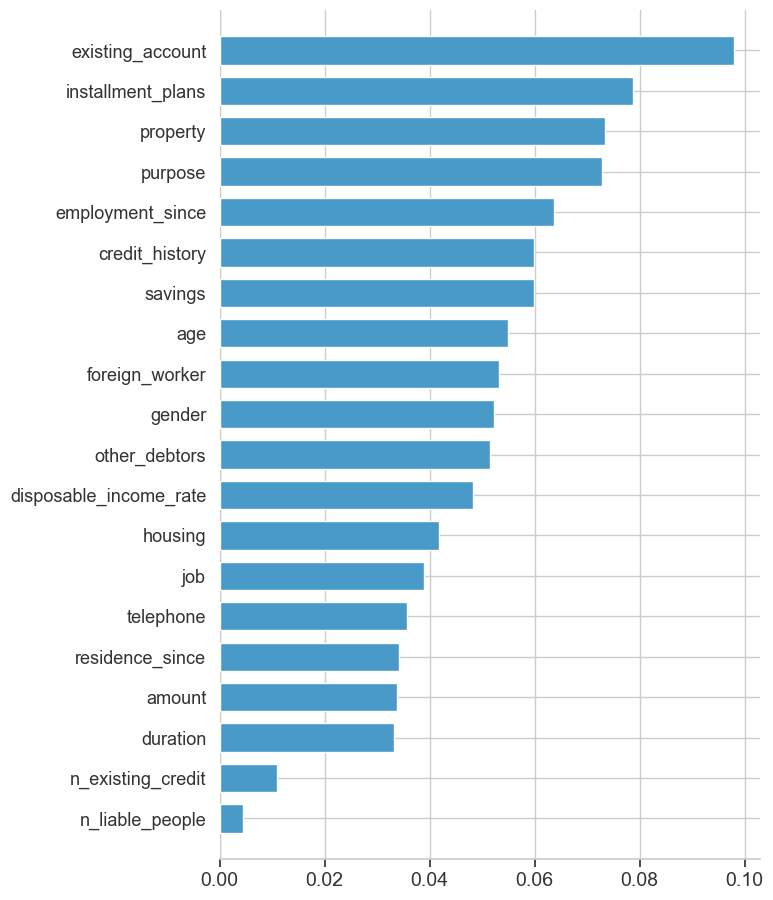

In [40]:
fig = plt.gcf()
shap.summary_plot(comp, plot_type='bar', feature_names=df_agg.columns, show=False, color='#499ac9')
plt.xlabel("")
plt.tick_params(axis='x', labelsize=14)
# plt.savefig("fcp_german_nomodulo_lelu.pdf", bbox_inches='tight')
plt.show()

In [41]:
df, ohe_df, X, Y = load_dataset(file, oclusion=True, o_feature='existing_account')
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=0)

In [42]:
Y_pred = model.predict(X_test)
print(accuracy_score(Y_test, np.round(Y_pred)))

0.685


### LRP

In [10]:
class RelevancePropagation(object):
    """Class that implements the layer-wise relevance propagation algorithm for keras Dense layers.
    """

    def __init__(self, model):
        self.epsilon = 1.0e-9
        self.rule = "z_plus"
        
        self.model = model

        # Extract model's weights
        self.weights = {weight.name.split('/')[0]: weight for weight in self.model.trainable_weights
                        if 'bias' not in weight.name}

        # Extract activation layers
        self.activations = [layer.output for layer in self.model.layers]
        self.activations = self.activations[::-1]

        # Extract the model's layers name
        self.layer_names = [layer.name for layer in self.model.layers]
        self.layer_names = self.layer_names[::-1]


    def run(self, X_test):
        """Computes feature relevance maps for an input.
        """
        
        f = K.function([self.model.input], [self.model.layers[1].output,
                                                           self.model.layers[2].output,
                                                           self.model.layers[3].output])
        
        outputs = f(X_test)
        weights = [self.model.layers[1].get_weights()[0], 
                   self.model.layers[2].get_weights()[0], 
                   self.model.layers[3].get_weights()[0]]
        
        relevance = outputs[-1]

        outputs = X_test + outputs
        
        for i in reversed(range(len(weights))):
            activation = outputs[i]
            matrix = weights[i]
            
            w_pos = np.maximum(matrix, 0.0)
            z = np.matmul(activation, w_pos) + self.epsilon
            s = relevance / z
            c = np.matmul(s, w_pos.T)
            relevance = c * activation
        
        return relevance

In [11]:
lrp = RelevancePropagation(model)
relevance_scores = lrp.run([X_test])

In [13]:
# aggregating values
ohe_features = ohe_df.columns[:-Y_train.shape[1]] # removing classes column names
df_lrp = pd.DataFrame(data=relevance_scores, columns=ohe_features)
prefixes = df.columns[:-1] # removing 'class' from original list of columns
df_agg = aggregate(df_lrp, prefixes)
agg_lrp = df_agg.values

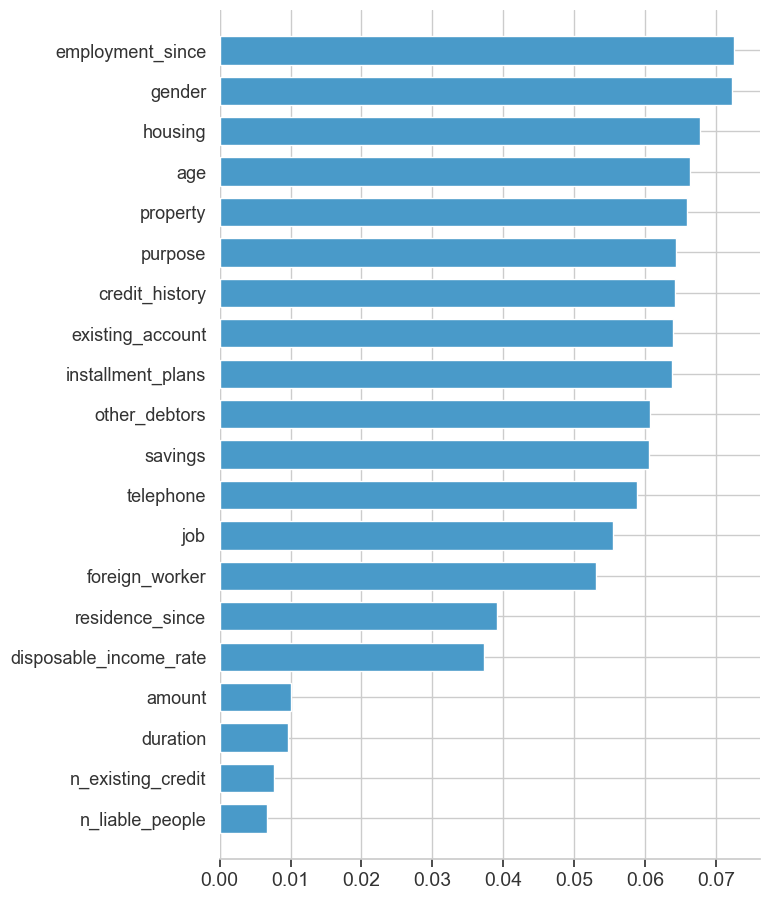

In [15]:
fig = plt.gcf()
# agg_lrp[:,[names_columns.tolist().index('gender'),names_columns.tolist().index('age')]]
shap.summary_plot(agg_lrp, plot_type='bar', feature_names=df_agg.columns, show=False, color='#499ac9')
plt.xlabel("")
plt.tick_params(axis='x', labelsize=14)
# plt.savefig("lrp_german_relu.pdf", bbox_inches='tight')
plt.show()

### SHAP

In [16]:
# background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]

explainer = shap.KernelExplainer(model, shap.kmeans(X_train, 100))
shap_values = explainer.shap_values(X_test)

  0%|          | 0/200 [00:00<?, ?it/s]

In [17]:
# aggregating values
ohe_features = ohe_df.columns[:-Y_train.shape[1]] # removing classes column names
df_shap = pd.DataFrame(data=shap_values[1], columns=ohe_features)
prefixes = df.columns[:-1] # removing 'class' from original list of columns
df_agg = aggregate(df_shap, prefixes)
agg_shap = df_agg.values

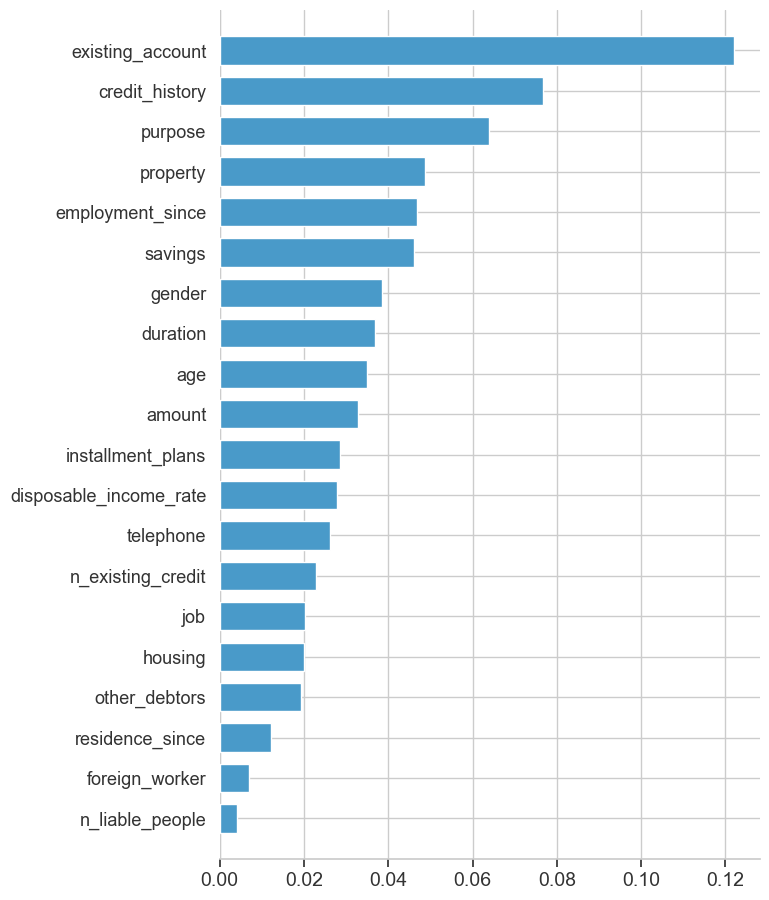

In [19]:
fig = plt.gcf()
# agg_shap[:,[names_columns.tolist().index('gender'),names_columns.tolist().index('age')]]
shap.summary_plot(agg_shap, plot_type='bar', feature_names=df_agg.columns, show=False, color='#499ac9')
plt.xlabel("")
plt.tick_params(axis='x', labelsize=14)
# plt.savefig("shap_german_relu.pdf", bbox_inches='tight')
plt.show()

### Figure example calculations

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

n11 = 0.5
a11 = 1
b11 = 0
c1 = [a11, b11]
print("c1", c1)

n12 = 0.8
a12 = 0
b12 = 1
c2 = [a12, b12]
print("c2", c2)

n21 = sigmoid(n11 * (-0.01) + n12 * 0.4) # b=0
a21 = a11 * abs(n11) * (-0.01) + a12 * abs(n12) * 0.4 
b21 = b11 * abs(n11) * (-0.01) + b12 * abs(n12) * 0.4 
c3 = [a21, b21]
sum_c3 = sum(map(abs, c3)) 
a21 = a21 / sum_c3
b21 = b21 / sum_c3
c3 = [round(a21,2), round(b21,2)]
print("c3", c3)

n22 = sigmoid(n11 * 0.3 + n12 * (-0.1))
a22 = a11 * abs(n11) * 0.3 + a12 * abs(n12) * (-0.1)
b22 = b11 * abs(n11) * 0.3 + b12 * abs(n12) * (-0.1)
c4 = [a22, b22]
sum_c4 = sum(map(abs, c4))
a22 = a22 / sum_c4
b22 = b22 / sum_c4
c4 = [round(a22,2), round(b22,2)]
print("c4", c4)

n23 = sigmoid(n11 * 0.8 + n12 * 0.6)
a23 = a11 * abs(n11) * 0.8 + a12 * abs(n12) * 0.6 
b23 = b11 * abs(n11) * 0.8 + b12 * abs(n12) * 0.6 
c5 = [a23, b23]
sum_c5 = sum(map(abs, c5)) 
a23 = a23 / sum_c5
b23 = b23 / sum_c5
c5 = [round(a23,2), round(b23,2)]
print("c5", c5)

n31 = sigmoid(n21 * 0.7 + n22 * (-0.2) + n23 * 0.3)
a31 = a21 * abs(n21) * 0.7 + a22 * abs(n22) * (-0.2) + a23 * abs(n23) * 0.3
b31 = b21 * abs(n21) * 0.7 + b22 * abs(n22) * (-0.2) + b23 * abs(n23) * 0.3
c6 = [a31, b31]
sum_c6 = sum(map(abs, c6))
a31 = a31 / sum_c6
b31 = b31 / sum_c6
c6 = [round(a31,2), round(b31,2)]
print("c6", c6)

n32 = sigmoid(n21 * (-0.5) + n22 * 0.1 + n23 * 0.4)
a32 = abs(n21) * a21 * (-0.5) + abs(n22) * a22 * 0.1 + abs(n23) * a23 * 0.4
b32 = abs(n21) * b21 * (-0.5) + abs(n22) * b22 * 0.1 + abs(n23) * b23 * 0.4
c7 = [a32, b32]
sum_c7 = sum(map(abs, c7))
a32 = a32 / sum_c7
b32 = b32 / sum_c7
c7 = [round(a32,2), round(b32,2)]
print("c6", c7)